• 교차검증의 본질
• 교차검증은 훈련 데이터만을 여러 번 나눠서 "훈련/검증"을 반복하며 일반화 성능을 추정하는 방법
• 각 fold에서 일부는 훈련, 일부는 검증(set) 역할을 번갈아 수행함
• 과적합 판정의 실무적 기준
• 훈련 데이터 내에서 교차검증을 반복하면, "훈련 성능"과 "교차검증(내부 검증) 성능"의 차이, 그리 고 검증 성능의 변동성으로 과적합 경향을 충분히 진단할 수 있음
• 실제로 실무/논문/대회 등에서 과적합 여부는 대부분 교차검증 결과로 판단함
• 최종 검증 데이터(test set)는 언제 쓰나?
• 최종 test set은 모델 개발이 모두 끝난 후" 진짜 미지 데이터에 대한 성능을 한 번만 평가할 때 사용
• 과적합 여부의 1차 판정은 교차검증(훈련 데이터 내부)에서 충분히 가능

In [9]:
# [1] 패키지 가져오기
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

In [10]:
# [2] 데이터 가져오기
origin = load_data("fish_processed")
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


In [11]:
# K-폴드 교차 검증
x = origin.drop("무게", axis=1)
y = origin["무게"]

estimator = LinearRegression(n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=52)

# 리턴값에 음수를 적용함에 주의
cv_rmse = -cross_val_score(
    estimator, x, y, cv=kf, scoring="neg_root_mean_squared_error"
)

cv_mean = cv_rmse.mean()
cv_std = cv_rmse.std()
print("CV RMSE 평균:", cv_mean)
print("CV RMSE 표준편차:", cv_std)

cv_ratio = cv_std / cv_mean
print("CV 변동성 비율:", cv_ratio)

if cv_ratio >= 0.20:
    print("→ 과적합 가능성 높음: 교차검증 성능이 불안정함")
elif cv_ratio >= 0.10:
    print("→ 과적합 의심: 교차검증 성능 변동이 있음")
else:
    print("→ 일반화 안정: 교차검증 성능이 안정적임")

CV RMSE 평균: 0.24818139899860095
CV RMSE 표준편차: 0.14368675110521353
CV 변동성 비율: 0.5789585830565147
→ 과적합 가능성 높음: 교차검증 성능이 불안정함


In [12]:
# 훈련/검증 데이터 분리
df = origin
yname = "무게"
x = df.drop(columns=[yname])
y = df[yname]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 3), (14, 3), (42,), (14,))

In [13]:
# 학습 모델 구축
estimator = LinearRegression(n_jobs=-1)
estimator.fit(x_train, y_train)

# Train RMSE 도출
y_train_pred = estimator.predict(x_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train RMSE:", rmse_train)

Train RMSE: 0.2600199723387838


In [14]:
# 교차검증 수행
kf = KFold(n_splits=5, shuffle=True, random_state=52)

cv_rmse = -cross_val_score(
    estimator, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
)

cv_mean = cv_rmse.mean()
cv_std = cv_rmse.std()
print("CV RMSE 평균:", cv_mean)
print("CV RMSE 표준편차:", cv_std)

CV RMSE 평균: 0.294966177046128
CV RMSE 표준편차: 0.1509287467651295


In [15]:
# 과적합 판정
cv_ratio = cv_std / cv_mean

# 기준값
LARGE = 1.2
SMALL = 0.9
STABLE = 0.10
UNSTABLE = 0.20

# 상대 비교
train_vs_cv = rmse_train / cv_mean

if train_vs_cv >= LARGE and cv_ratio <= STABLE:
    print("→ 과소적합: 모델이 너무 단순함")
elif train_vs_cv <= SMALL and cv_ratio >= UNSTABLE:
    print("→ 과대적합: 일반화 실패")
elif train_vs_cv <= SMALL and cv_ratio <= STABLE:
    print("→ 일반화 양호: 이상적 상태")
elif train_vs_cv <= SMALL and cv_ratio > STABLE:
    print("→ 데이터 부족 가능성: 표본 수 문제")
else:
    print("→ 판단 유보: 추가 지표 필요")

→ 과대적합: 일반화 실패


In [17]:
# 학습곡선 시각화
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator,
    X=x,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True,
    random_state=52,
)

# neg RMSE → RMSE
train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균 / 표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

# 마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]
gap_ratio = final_train / final_cv
var_ratio = final_std / final_cv

# 판정 로직
if gap_ratio >= 1.2 and var_ratio <= 0.10:
    status = "→ 과소적합 (모델이 너무 단순)"
elif gap_ratio <= 0.9 and var_ratio >= 0.20:
    status = "→ 과대적합 (일반화 실패)"
elif gap_ratio <= 0.9 and var_ratio <= 0.10:
    status = "→ 일반화 양호"
elif gap_ratio <= 0.9 and var_ratio > 0.10:
    status = "→ 데이터 부족 (표본 수 문제)"
else:
    status = "→ 판단 유보"

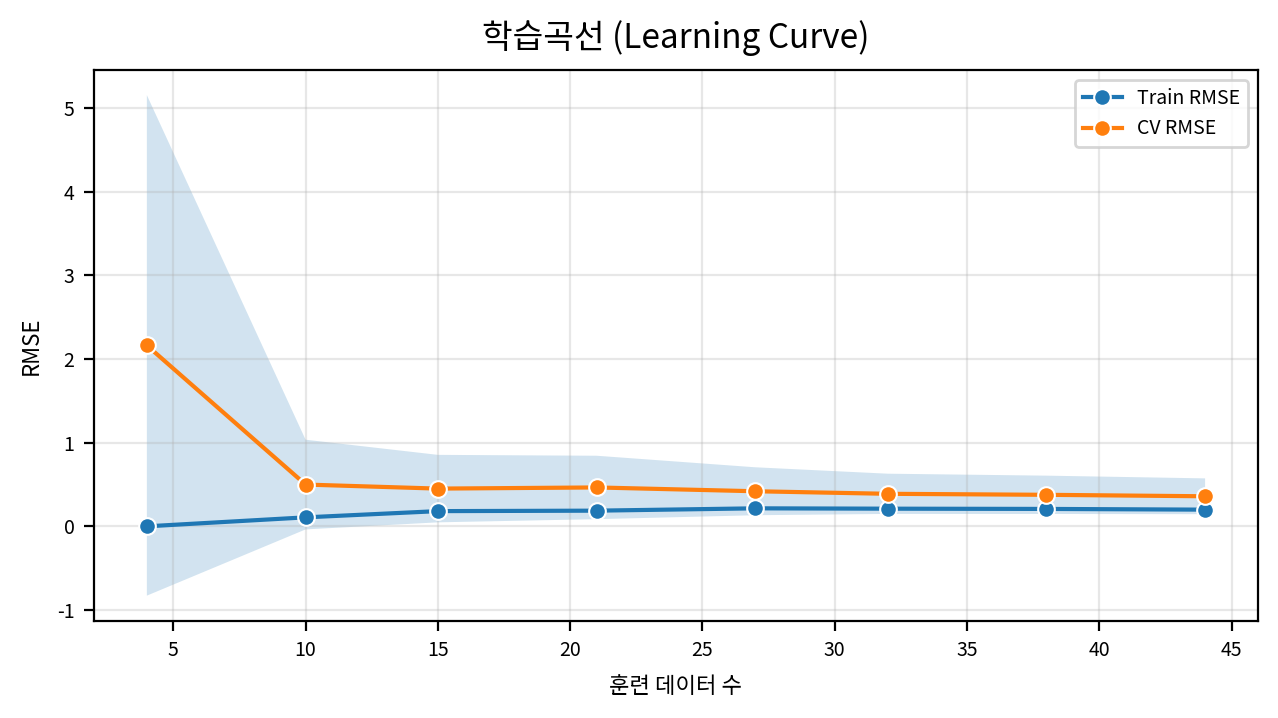

In [18]:
# 시각화
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.lineplot(
    x=train_sizes,
    y=train_mean,
    marker="o",
    markeredgecolor="#ffffff",
    label="Train RMSE",
)
sb.lineplot(
    x=train_sizes,
    y=cv_mean,
    marker="o",
    markeredgecolor="#ffffff",
    label="CV RMSE",
)
plt.fill_between(
    train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2, label="CV ± 1 std"
)

ax.set_title("학습곡선 (Learning Curve)", fontsize=12, pad=8)
ax.set_xlabel("훈련 데이터 수", fontsize=8, labelpad=5)
ax.set_ylabel("RMSE", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [19]:
# 정량 결과 표
result_df = DataFrame(
    {
        "지표": [
            "Train RMSE",
            "CV RMSE 평균",
            "CV RMSE 표준편차",
            "Train/CV 비율",
            "CV 변동성 비율",
            "판정 결과",
        ],
        "값": [
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ],
    }
)
result_df

,지표,값
0,Train RMSE,0.199385
1,CV RMSE 평균,0.359186
2,CV RMSE 표준편차,0.213944
3,Train/CV 비율,0.555101
4,CV 변동성 비율,0.595635
5,판정 결과,→ 과대적합 (일반화 실패)
